In [3]:
import glob, re
import numpy as np
from numpy import log as ln
import pandas as pd
import matplotlib.pyplot as plt
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'qt') # switch from inline to qt if i change the incline to qt here
from IPython.core.display import Image, display
# def getInfo(file, pos, reps): not functional atm
#     """
#     Takes and SPIP exportet ASCII file of linespectra
#     Returns the pixel coordinates of each spectra position"""
#     string = "I(V) 4 (STS_LOCATION-338,52;9.60938e-009,-2.39063e-008) Forward Sun May 30 20.42.05 2021 [44-1]  STM_NANOPROBE_AtomManipulation STM (12, 51)"
#     topo_str = '\[\d+\-\d\]'
#     with  open(file,'r') as f:
#         info = pd.read_csv(f, delimiter='\t\t', skiprows=5, nrows=1, header=None, engine='python')
#     topo = re.findall(info.iloc[0,0],topo_str)[0]
# #     for i in range(int(len(info.columns)/reps)):
# #         x = re.match(info[][i], string)
# #         print(info[:][i])
#     return info, topo
    
def asc2dict(file):
    """
    Takes an ascii text file produced by SPIP for Omicron linespectra series.
    Returns a dataframe with the data
    """
    df = {}
    with  open(file,'r') as f:
        df = pd.read_csv(f, delimiter='\t', skiprows=8, header=None, engine='python')
    return df

def avg(data, pts, pos, reps):
    """
    Takes a pandas dataframe and, V-resolution (pts), 
    number of positions (pos) and repetitions in each pos (reps).
    Returns the averaged (mean) data in a nupmy array
    """
    avg = np.zeros((pos, pts))
    for i in range(pos):
        avg[i] = data.iloc[:,i*reps:(1+i)*reps].mean(axis=1)
    return avg.T

## Get data 

In [4]:
# manually insert metadata here:
pts = 251  # points V-resolution of spectra
reps = 80 # repetitions in one position
pos = 70   # number of positions
l = 29.9     #length of line in nm
fac = 1e-9 # calibration factor to convert voltage signal to current

d = np.arange(0,l,l/pos)  #distance vector for plotting


X = asc2dict('AUX1(V)_5600 Profiles Spectroscopy.asc')
volt = X[0]  # voltage vector for plotting
# a[start:end:step], what steffen did here is to average the 100 repetitons of each point, so i get a 251x30 array
X = avg(X[X.columns[1::2]], pts, pos, reps)*fac 


IV = asc2dict('I(V)_5600 Profiles Spectroscopy.asc')
IV = avg(IV[IV.columns[1::2]], pts, pos, reps)

Y = asc2dict('AUX1(V)_5600 Profiles Spectroscopy.asc')
Y = avg(Y[Y.columns[1::2]], pts, pos, reps)*fac

## rolling average method No.1, slightly modified to have same length for output as input

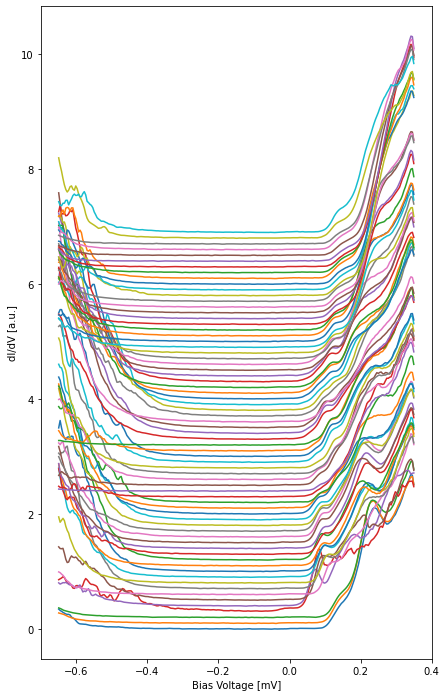

In [6]:
# rolling/moving average every n points of the data
# here is the reference link of the rolling/moving average: https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-python-numpy-scipy
# inline = plot in Jupyter notebook.
# auto = whatever matplotlib wants (normally creates a plot window).
%matplotlib inline

# it will averaging every n points, but the same length for output as input 
def mov_avg(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

# Specify graph separation as desired. 
separation = 0.1
window_size = 1 

# Transpose the matrix to make it easier to modify the graphs individually.
X_offset = np.array(X.copy())
X_offset = np.transpose(X_offset)

X_mov_avg = np.empty((len(X_offset), len(volt)), dtype=float)

for i in range(len(X_offset)):
    X_mov_avg[i] = mov_avg(X_offset[i], n=window_size)

for i in range(len(X_mov_avg)):
    X_mov_avg[i] += separation * i

# Transpose it back to its original form.
X_mov_avg = np.transpose(X_mov_avg)

fig, ax = plt.subplots(figsize=(7,12))
#print(volt[:-window_size + 1]) #here is the new lenth of the "Volt", so that it matches the lenth of Y after moving average.

ax.plot(volt, X_mov_avg)
# print(X_moving_avg)
# print(len(X_moving_avg))

ax.set(xlabel='Bias Voltage [mV]', ylabel='dI/dV [a.u.]')
# plt.xlim([-75, 260])
# plt.ylim([-0.01, 6])
plt.show()
# X_mov_avg

## the STS of global average/ all / selected points 

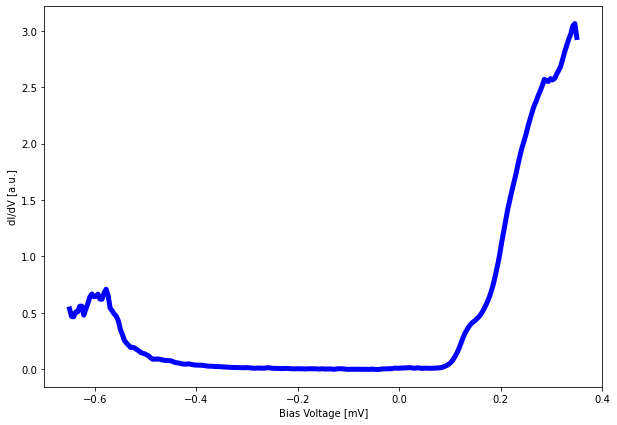

In [7]:
## another way of doing global mean of the data or selected points!
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,7))
# plt.plot(volt, X_mov_avg[:, 0], color='blue', linewidth=5.0) # using the rolling average data
plt.plot(volt, X[:,-1], color='blue', linewidth=5.0) ##X[:,-7:] means taking an vaerage pf the last 7 points.
#plt.plot(volt, np.mean(X,axis=1), color='blue', marker='o', markersize=5) #average of all 30 points

ax.set(xlabel='Bias Voltage [mV]', ylabel='dI/dV [a.u.]')
plt.rcParams['font.size'] = '16'
# plt.xlim([-50, 150])
# plt.ylim([0, 2])
plt.show()

## Plot color mesh of data 

## der for the data and find the peaks

In [8]:
# inline = plot in Jupyter notebook.
# auto = whatever matplotlib wants (normally creates a plot window).
%matplotlib qt

## peaks finding 
from scipy.signal import find_peaks
center = 190
dV = 13
w_min = np.ones(X.shape[0])*1000
w_min[center-dV:center+dV] = 1

fig, ax = plt.subplots(figsize=(10,20))
for i in range(70): # find peqaks of all the 70 points
    x = X[:,i]
    der = np.gradient(x)
    peaks, _ = find_peaks(der, width=w_min, prominence=0.01)
    ax.plot(volt,x+0.1*i)
    ax.scatter(volt[peaks],x[peaks]+0.1*i, color="red", marker='*', s=80)
ax.set(xlim=[0,0.2], ylim=[0,7.5])
plt.show()


In [226]:
# inline = plot in Jupyter notebook.
# auto = whatever matplotlib wants (normally creates a plot window).
%matplotlib qt

## peaks finding 
from scipy.signal import find_peaks
center = 190  #this is the peak position where we think it is second confined state. 
dV = 15
w_min = np.ones(X.shape[0])*1000
w_min[center-dV:center+dV] = 1

peaks = np.zeros(70)

fig, ax = plt.subplots(figsize=(7,10))
for i in range(47,70): ## here is define which data you want to plot out, (47,70) is the last 23 points
    x = X[:,i]
    der = np.gradient(x)
    peaks[i], _ = find_peaks(der, width=w_min, prominence=0.008)
    #print(peaks)
    ax.plot(volt,x+0.1*i)
    ax.scatter(volt[int(peaks[i])],x[int(peaks[i])]+0.1*i, color="red", marker='*', s=80)
ax.set(xlim=[0,0.2], ylim=[4,8])
plt.show()


In [9]:
# inline = plot in Jupyter notebook.
# auto = whatever matplotlib wants (normally creates a plot window).
%matplotlib qt

## peaks finding 
from scipy.signal import find_peaks
center = 190  #this is the peak position where we think it is second confined state. 
dV = 10
w_min = np.ones(X.shape[0])*500
w_min[center-dV:center+dV] = 1.1

peaks = np.zeros(70)

fig, ax = plt.subplots(figsize=(5,7))
for i in range(6,46): ## here is define which data you want to plot out, (47,70) is the last 23 points, or just (70) will be the 70 points.
    x = X[:,i]
    der = np.gradient(x)
    peaks[i], _ = find_peaks(der, width=w_min, prominence=0.05)
#     print(peaks)
    ax.plot(volt,x+0.05*i)
    ax.scatter(volt[int(peaks[i])],x[int(peaks[i])]+0.05*i, color="red", marker='*', s=80) #scatter plot with offsetting the plots.
# ax.set(xlim=[0,0.2], ylim=[0.5,4])
plt.show()

ValueError: setting an array element with a sequence.

## plot der and STS in one graph

In [10]:
#X = asc2dict('AUX1(V)_5600 Profiles Spectroscopy.asc')
#X = avg(X[X.columns[1::2]], pts, pos, reps)*fac 
der = np.gradient(X[:,6]) #der of the dI/dV data, and which points you want to plot out

## plot the original data and der in one graph with individual y.
fig, ax = plt.subplots()
ax.plot(volt, X[:,6], color='red', linewidth=3)
ax.set_xlabel("bias (V)", fontsize=14)
ax.set_ylabel("dI/dV (a.u.)",color="red",fontsize=14)

ax2=ax.twinx()
ax2.plot(volt, der, color='blue', linewidth=3)
ax2.set_ylabel("grad (dI/dV)",color="blue",fontsize=14)

# plt.xlim([-0.05, 0.2])
# plt.ylim([-0.78, -0.69])
# ax2.set(ylim=[-0.005, 0.1])
plt.show()


In [157]:
## peaks finding 
from scipy.signal import find_peaks

#X = asc2dict('AUX1(V)_5600 Profiles Spectroscopy.asc')
#X = avg(X[X.columns[1::2]], pts, pos, reps)*fac 
#der = np.gradient(np.mean(X,axis=1))

ax.plot(volt, der, color='blue', linewidth=3)
ax.set_xlabel("bias (V)", fontsize=14)
ax.set_ylabel("grad (dI/dV)",color="blue",fontsize=14)
plt.plot(volt,der)

w_min = np.ones(X.shape[0])*100
w_min[193-10:193+10] = 0.1 

peaks, _ = find_peaks(der, width=w_min)
plt.scatter(volt[peaks],der[peaks], color="red", marker='*', s=80)

#plt.xlim([-0.05, 0.2])
#plt.ylim([-0.001, 0.06])
plt.show()
# list(peaks)
# plt.errorbar(x, y, yerr=err, fmt='o')